In [1]:
#Importing The Required Libraries & Packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

C:\Users\ACER\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from math import sqrt
from sklearn.metrics import r2_score , mean_absolute_error , mean_absolute_percentage_error , mean_squared_error
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('exchange_rate.csv')
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [4]:
df.shape

(7588, 2)

In [5]:
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df.dtypes

date        object
Ex_rate    float64
dtype: object

In [8]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [10]:
#Changing the data type of Date column as Date using pandas command

df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')


In [11]:
#Changing the Date columns as the index column of the dataset and also displaying the first five records of the dataset
df.set_index('date',inplace = True)


In [12]:
df.head()

,Ex_rate
date,
1990-01-01,0.7855
1990-01-02,0.7818
1990-01-03,0.7867
1990-01-04,0.7860
1990-01-05,0.7849


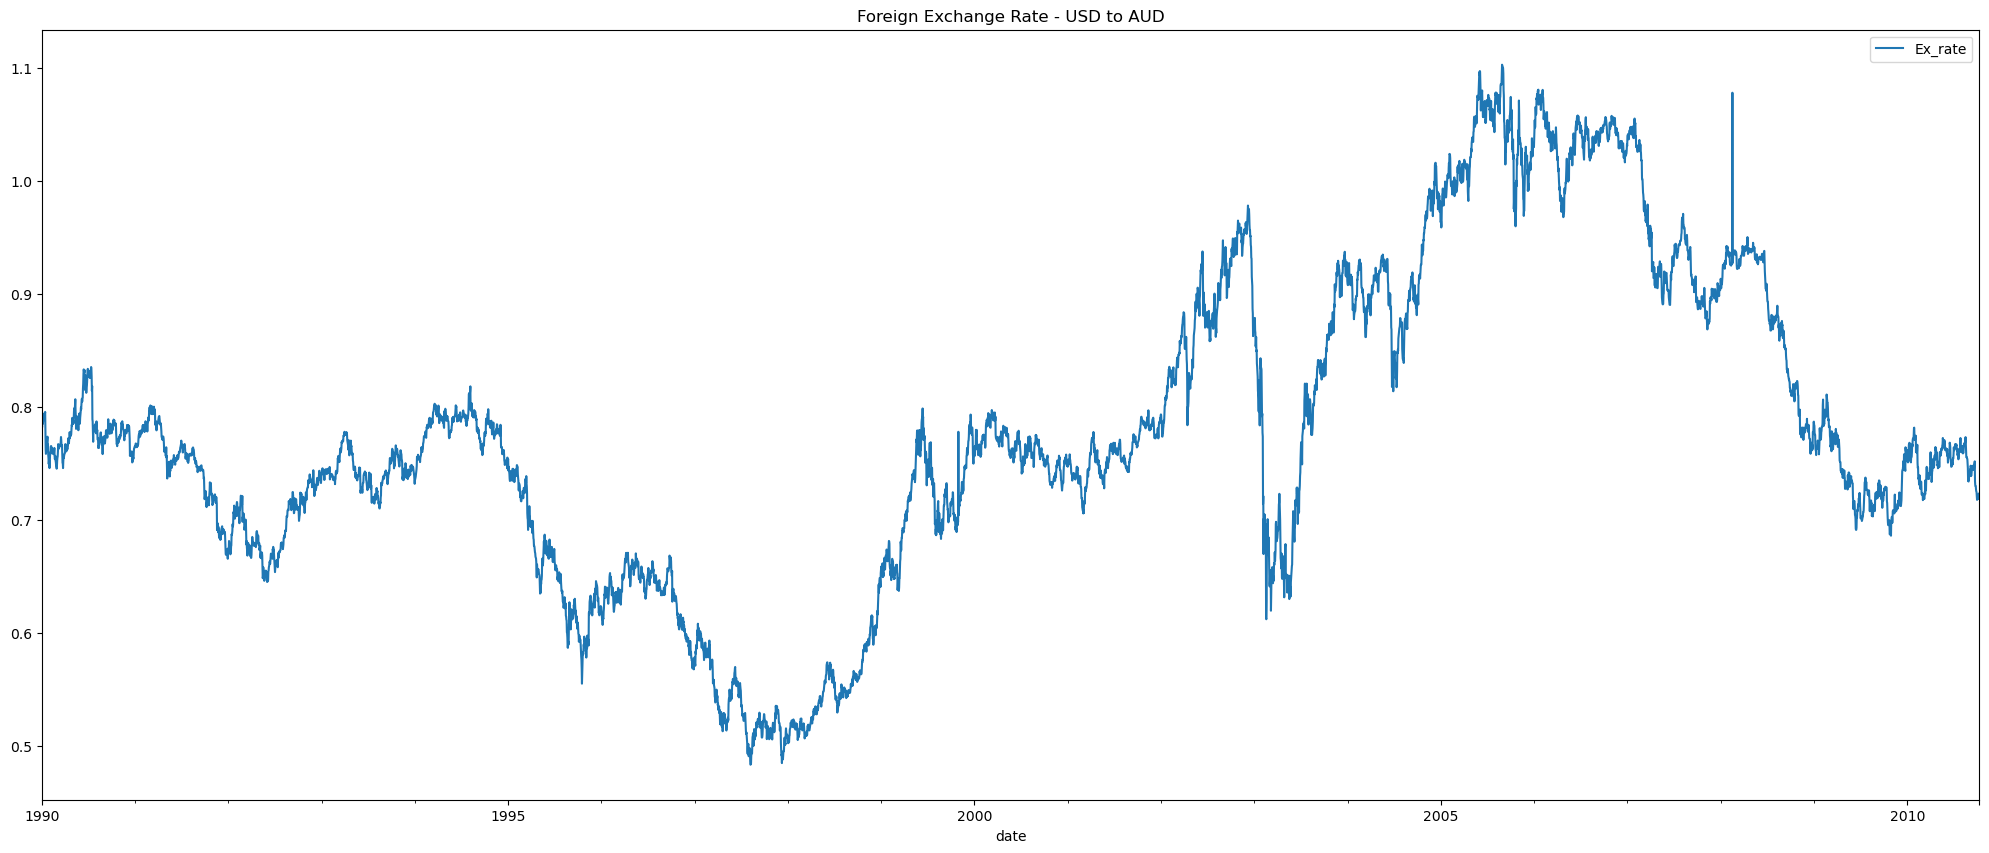

In [13]:
#Plotting the line graph to show the data trend in the dataset 

df.plot(figsize = (25,10))
plt.title('Foreign Exchange Rate - USD to AUD')
plt.savefig('Foreign Exchange Rate - USD to AUD.png')
plt.show()

In [14]:
#Resampling the dataset to weekly frequency since the given data has more number of observations that takes longer time to
#fit or predict the model. And along with that showing number of observation after resampling and displaying the first five
#record of resampled dataset

In [15]:
df_week = df.resample('W').mean()
print('Count of The Weekly Data Frame : ',df_week.shape[0])
df_week.head()

Count of The Weekly Data Frame :  1084


,Ex_rate
date,
1990-01-07,0.785729
1990-01-14,0.792714
1990-01-21,0.764871
1990-01-28,0.762429
1990-02-04,0.753529


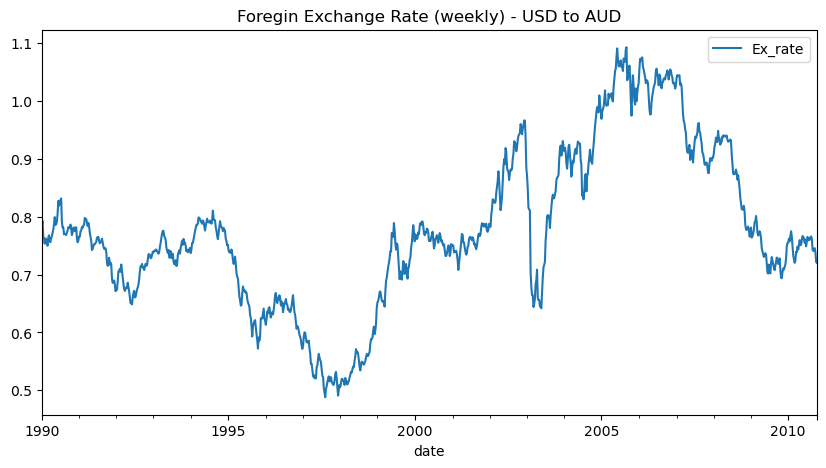

In [16]:
df_week.plot(figsize = (10,5))
plt.title('Foregin Exchange Rate (weekly) - USD to AUD')
plt.show()

In [17]:
df_month = df.resample('M').mean()
print('Count of The Monthly Data Frame : ',df_month.shape[0])
df_month.head()

Count of The Monthly Data Frame :  250


,Ex_rate
date,
1990-01-31,0.773874
1990-02-28,0.757486
1990-03-31,0.760365
1990-04-30,0.770110
1990-05-31,0.789684


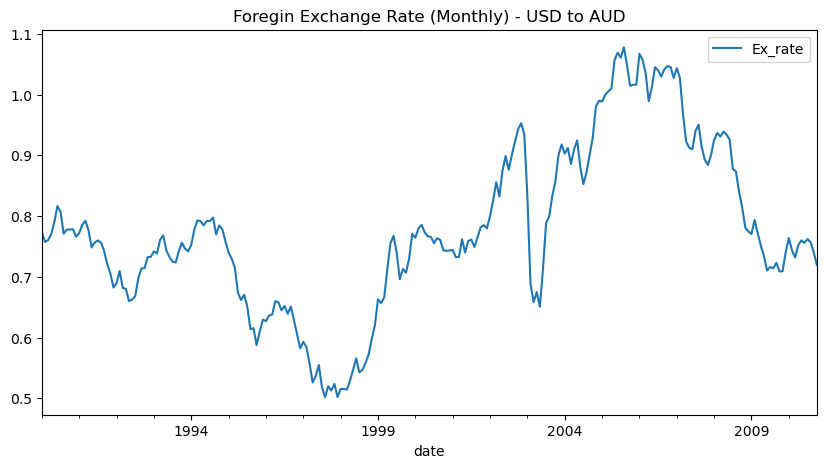

In [18]:
df_month.plot(figsize = (10,5))
plt.title('Foregin Exchange Rate (Monthly) - USD to AUD')
plt.show()

In [19]:
df_year = df.resample('Y').mean()
print('Count of The Yearly Data Frame : ',df_year.shape[0])
df_year.head()

Count of The Yearly Data Frame :  21


,Ex_rate
date,
1990-12-31,0.778996
1991-12-31,0.749830
1992-12-31,0.695201
1993-12-31,0.743442
1994-12-31,0.781024


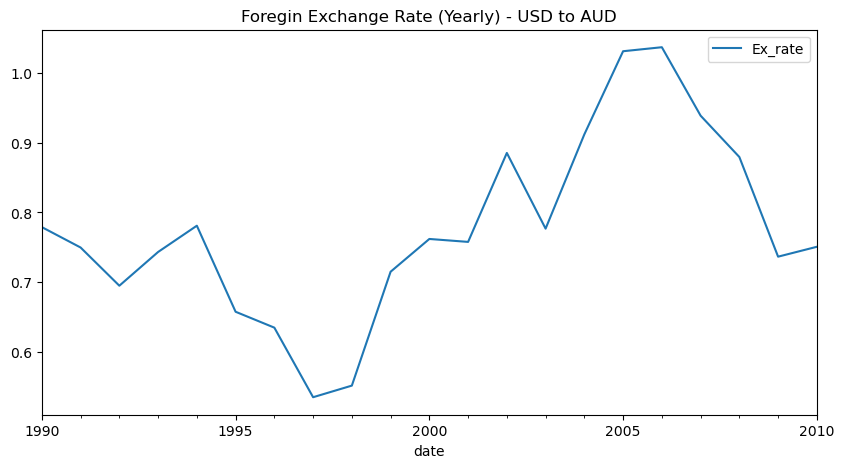

In [20]:
df_year.plot(figsize = (10,5))
plt.title('Foregin Exchange Rate (Yearly) - USD to AUD')
plt.show()

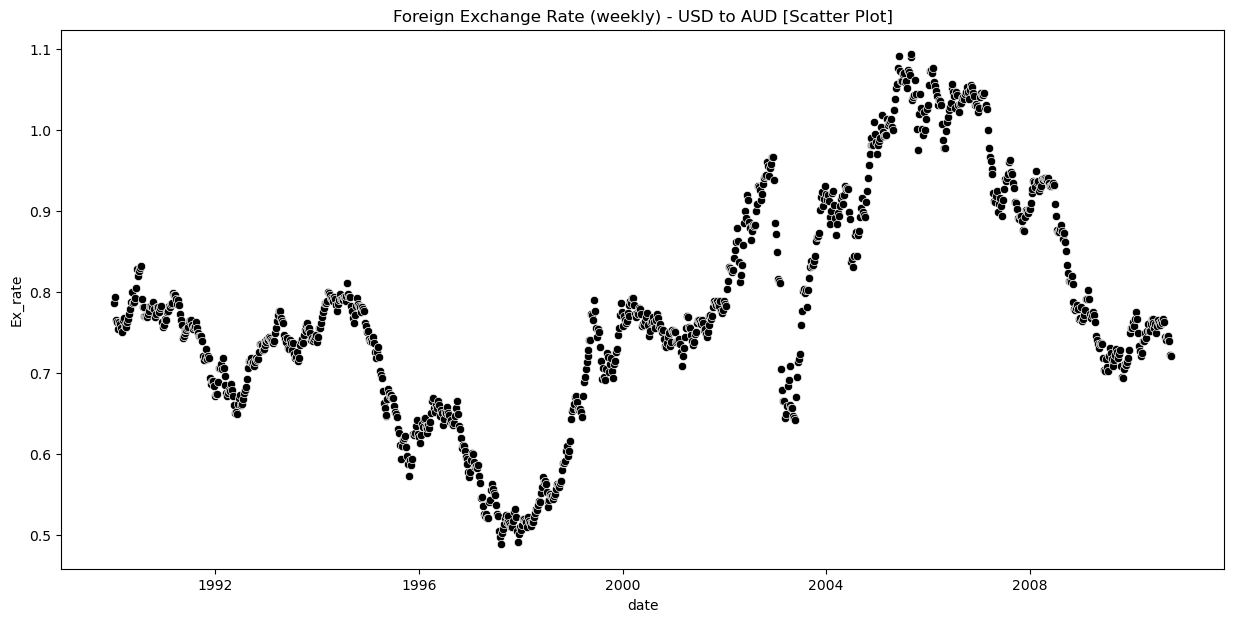

In [21]:
plt.rcParams['figure.figsize'] = (15,7)
sns.scatterplot(x = df_week.index , y = df_week.Ex_rate , color = 'black')
plt.title('Foreign Exchange Rate (weekly) - USD to AUD [Scatter Plot]')
plt.show()

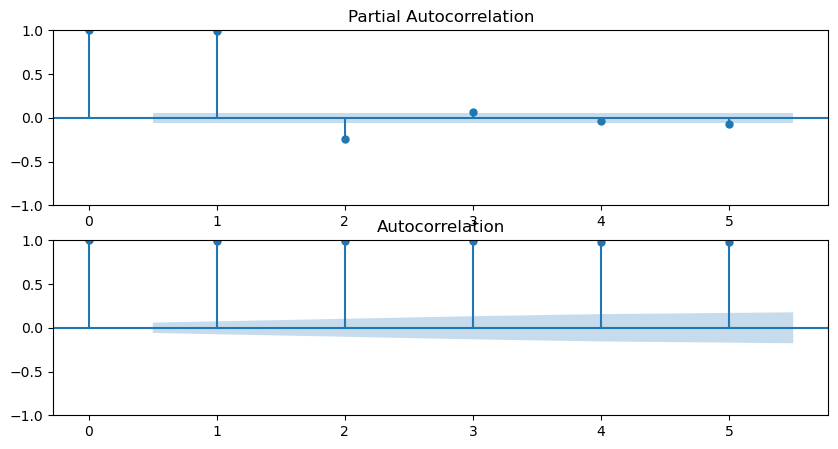

In [26]:
fig , (ax1,ax2) = plt.subplots(nrows = 2 ,ncols = 1,sharex = False , sharey = False , figsize = (10,5))
ax1 = plot_pacf(df_week , lags = 5 , ax = ax1)
ax2 = plot_acf(df_week , lags = 5 , ax = ax2)
plt.savefig('Partial Autocorrelation and Autocorrelation.png')
plt.show()

In [27]:
# Check for missing values
missing_values = df_week.isnull().sum()
print(missing_values)

Ex_rate    0
dtype: int64


In [28]:
# Check for infinite values
infinite_values = np.isinf(df_week).sum()
print(infinite_values)

Ex_rate    0
dtype: int64


In [29]:
# Remove rows with missing values
df_week = df_week.dropna()

In [30]:
# Check for missing values
missing_values = df_week.isnull().sum()
print(missing_values)

Ex_rate    0
dtype: int64


In [31]:
def adf_check(time_series):
    result = adfuller(time_series , autolag = 'AIC')
    label = pd.Series(result[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in result[4].items():
        label['Critical Value (%s)'%key] = value
    print(label)
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis, hence REJECT null hypothesis and the series is Stationary')
    else:
        print ('Weak evidence against the null hypothesis, hence ACCEPT null hypothesis and the series is Not Stationary ')

In [32]:
adf_check(df_week)

Test Statistic                   -1.800054
p-value                           0.380435
Number of Lags Used               4.000000
Number of Observations Used    1079.000000
Critical Value (1%)              -3.436425
Critical Value (5%)              -2.864222
Critical Value (10%)             -2.568198
dtype: float64
Weak evidence against the null hypothesis, hence ACCEPT null hypothesis and the series is Not Stationary 


# Since the time series is not a stationary , the resampled weekly dataset is transformed as a new dataframe with first difference to make it as a stationary series. Along with that showing number of observation in the new dataframe and displaying the first five record of the new data frame

In [33]:
df1_week = df_week.diff().dropna()
print('Count of weekly First Difference',df1_week.shape[0])
df1_week.head()

Count of weekly First Difference 1083


,Ex_rate
date,
1990-01-14,0.006986
1990-01-21,-0.027843
1990-01-28,-0.002443
1990-02-04,-0.008900
1990-02-11,0.009114


In [34]:
#Performing the Augmented Dickey Fuller Test on the new transformed data in the resampled weekly dataset to find whether the time series is a stationary or not

In [35]:
adf_check(df1_week)

Test Statistic                -1.434209e+01
p-value                        1.055846e-26
Number of Lags Used            3.000000e+00
Number of Observations Used    1.079000e+03
Critical Value (1%)           -3.436425e+00
Critical Value (5%)           -2.864222e+00
Critical Value (10%)          -2.568198e+00
dtype: float64
Strong evidence against the null hypothesis, hence REJECT null hypothesis and the series is Stationary


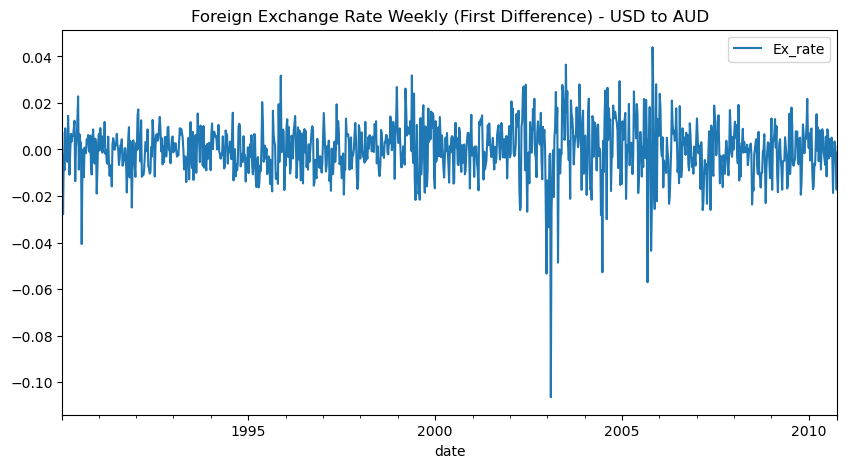

In [36]:
df1_week.plot(figsize = (10,5))
plt.title('Foreign Exchange Rate Weekly (First Difference) - USD to AUD')
plt.savefig('Foreign Exchange Rate Weekly(First Difference) - USD to AUD.png')
plt.show()

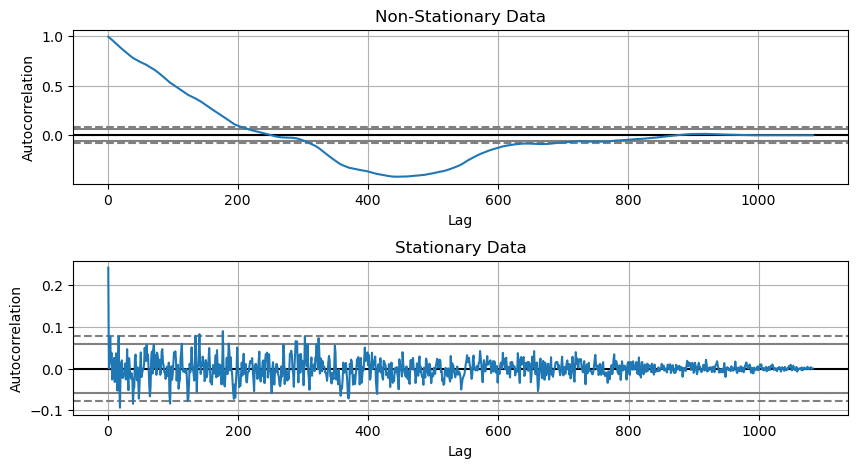

In [37]:
fig , (ax1,ax2) = plt.subplots(nrows = 2 ,ncols = 1,sharex = False , sharey = False , figsize = (10,5))
ax1 = autocorrelation_plot(df_week , ax = ax1)
ax1.set_title('Non-Stationary Data')
ax2 = autocorrelation_plot(df1_week , ax = ax2)
ax2.set_title('Stationary Data')
plt.subplots_adjust(hspace = 0.5)
plt.savefig('Stationary data and Non-Stationary data.png')
plt.show()

In [38]:
model = auto_arima(df_week , m = 52, d = 1 ,seasonal = False , max_order = 8 , test = 'adf' , trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6685.063, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6624.331, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6687.232, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6691.370, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6626.300, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6689.294, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6689.240, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6687.279, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-6693.352, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6691.277, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-6691.222, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-6689.215, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-6689.262, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.815 seconds


In [39]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1084
Model:               SARIMAX(0, 1, 1)   Log Likelihood                3348.676
Date:                Thu, 12 Sep 2024   AIC                          -6693.352
Time:                        00:59:49   BIC                          -6683.377
Sample:                    01-07-1990   HQIC                         -6689.575
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2606      0.026      9.968      0.000       0.209       0.312
sigma2         0.0001   2.14e-06     56.284      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              4493.99
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                            -1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
model = ARIMA(df_week , order = (0,1,1))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                 1084
Model:                 ARIMA(0, 1, 1)   Log Likelihood                3348.676
Date:                Thu, 12 Sep 2024   AIC                          -6693.352
Time:                        01:00:53   BIC                          -6683.377
Sample:                    01-07-1990   HQIC                         -6689.575
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2606      0.026      9.968      0.000       0.209       0.312
sigma2         0.0001   2.14e-06     56.284      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              4493.99
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                            -1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
predictions = result.predict(typ = 'levels')

In [43]:
print('Evaluation Result for whole data : ','\n')
print('R2 Score for whole data : {0:.2f} %'.format(100*r2_score(df_week['Ex_rate'],predictions)),'\n')
print('Mean Squared Error : ',mean_squared_error(df_week['Ex_rate'],predictions),'\n')
print('Mean Absolute Error : ',mean_absolute_error(df_week['Ex_rate'],predictions),'\n')
print('Root Mean Squared Error : ',sqrt(mean_squared_error(df_week['Ex_rate'],predictions)),'\n')
print('Mean Absolute Percentage Error : {0:.2f} %'.format(100*mean_absolute_percentage_error(df_week['Ex_rate'],predictions)))

Evaluation Result for whole data :  

R2 Score for whole data : 96.29 % 

Mean Squared Error :  0.0006901464428926093 

Mean Absolute Error :  0.00865441827513412 

Root Mean Squared Error :  0.02627063841806303 

Mean Absolute Percentage Error : 1.12 %


In [45]:
Final_data = pd.concat([df_week,df1_week,predictions],axis=1)
Final_data.columns = ['Foreign Exchange Rate (weekly)','Weekly First Difference','Predicted Exchange Rate']
Final_data.to_csv('Foreign Exchange Rate with Prediction (USD to AUD).csv')
Final_data.head()

,Foreign Exchange Rate (weekly),Weekly First Difference,Predicted Exchange Rate
date,,,
1990-01-07,0.785729,NaN,0.000000
1990-01-14,0.792714,0.006986,0.785729
1990-01-21,0.764871,-0.027843,0.794419
1990-01-28,0.762429,-0.002443,0.757203
1990-02-04,0.753529,-0.008900,0.763790


In [46]:
#Splliting the Resampled Weekly Dataset into training data and test data. Displaying the number of observations in both training data and test data.

In [47]:
size = int(len(df_week)*0.80)
train , test = df_week[0:size]['Ex_rate'] , df_week[size:(len(df_week))]['Ex_rate']
print('Counts of Train Data : ',train.shape[0])
print('Counts of Train Data : ',test.shape[0])

Counts of Train Data :  867
Counts of Train Data :  217


In [48]:
train_values = [x for x in train]
prediction = []
print('Printing Predictied vs Expected Values....')
print('\n')
for t in range(len(test)):
    model = ARIMA(train_values , order = (0,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    pred_out = output[0]
    prediction.append(float(pred_out))
    test_in = test[t]
    train_values.append(test_in)
    print('Predicted = %f , Actual = %f' % (pred_out , test_in))

Printing Predictied vs Expected Values....


Predicted = 1.020466 , Actual = 1.031167
Predicted = 1.033863 , Actual = 1.033182
Predicted = 1.033011 , Actual = 1.038432
Predicted = 1.039798 , Actual = 1.039574
Predicted = 1.039517 , Actual = 1.037241
Predicted = 1.036668 , Actual = 1.044465
Predicted = 1.046428 , Actual = 1.046676
Predicted = 1.046738 , Actual = 1.052859
Predicted = 1.054400 , Actual = 1.046291
Predicted = 1.044253 , Actual = 1.037256
Predicted = 1.035495 , Actual = 1.048507
Predicted = 1.051772 , Actual = 1.054639
Predicted = 1.055358 , Actual = 1.052527
Predicted = 1.051816 , Actual = 1.044990
Predicted = 1.043273 , Actual = 1.041232
Predicted = 1.040719 , Actual = 1.030797
Predicted = 1.028299 , Actual = 1.032021
Predicted = 1.032956 , Actual = 1.028472
Predicted = 1.027345 , Actual = 1.021559
Predicted = 1.020104 , Actual = 1.026367
Predicted = 1.027940 , Actual = 1.039732
Predicted = 1.042701 , Actual = 1.044737
Predicted = 1.045250 , Actual = 1.043060
Predicted = 

In [49]:
print('Evaluation Result for Test data : ','\n')
print('R2 Score for Test data : {0:.2f} %'.format(100*r2_score(test,prediction)),'\n')
print('Mean Squared Error : ',mean_squared_error(test,prediction),'\n')
print('Mean Absolute Error : ',mean_absolute_error(test,prediction),'\n')
print('Root Mean Squared Error : ',sqrt(mean_squared_error(test,prediction)),'\n')
print('Mean Absolute Percentage Error : {0:.2f} %'.format(100*mean_absolute_percentage_error(test,prediction)))

Evaluation Result for Test data :  

R2 Score for Test data : 99.34 % 

Mean Squared Error :  7.930221814060159e-05 

Mean Absolute Error :  0.006992659438952315 

Root Mean Squared Error :  0.008905179287392343 

Mean Absolute Percentage Error : 0.84 %


In [50]:
predictions_df = pd.Series(prediction, index = test.index)

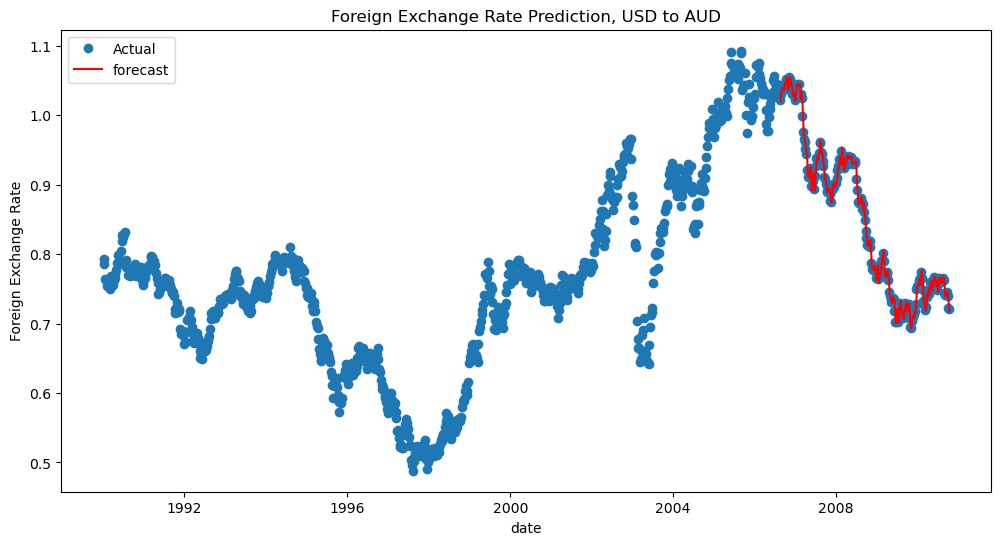

In [51]:
#Plotting the graph with predicted data and resampled weekly data index since the prediction is based on test data.

plt.rcParams['figure.figsize'] = (12,6)
fig, ax = plt.subplots()
ax.set(title='Foreign Exchange Rate Prediction, USD to AUD', xlabel='date', ylabel='Foreign Exchange Rate')
ax.plot(df_week, 'o', label='Actual')
ax.plot(predictions_df, 'r', label='forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
plt.savefig('Foreign Exchange Rate Prediction - USD to AUD.png')